### Data Dictionary

    1 conservative 0 liberal
    circum1st - 11th, DC, and FED
    unconst -  0 petitioner did not argue unconstitutionality, 1 petitioner argued unconstitutionality
    lctdir - conser  liberal
    petitnum, respnum - 
    DEFINDIP criminal defendant, Indian, injured person
    EE employee
    CITSTAT city, state
    OF POL  government official, politician
    US  United States
    BUSER  business, employer

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("stevens.csv")

In [3]:
df

,Docket,Term,Circuit,Issue,Petitioner,Respondent,LowerCourt,Unconst,Reverse
0,93-1408,1994,2nd,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
1,93-1577,1994,9th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
2,93-1612,1994,5th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
3,94-623,1994,1st,EconomicActivity,BUSINESS,BUSINESS,conser,0,1
4,94-1175,1995,7th,JudicialPower,BUSINESS,BUSINESS,conser,0,1
...,...,...,...,...,...,...,...,...,...
561,99-5153,1999,6th,CriminalProcedure,OTHER,US,conser,0,0
562,99-804,2000,5th,CriminalProcedure,OTHER,US,liberal,0,1
563,99-8508,2000,9th,CriminalProcedure,OTHER,US,conser,1,0
564,97-29,1997,DC,CivilRights,STATE,US,conser,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Docket      566 non-null    object
 1   Term        566 non-null    int64 
 2   Circuit     566 non-null    object
 3   Issue       566 non-null    object
 4   Petitioner  566 non-null    object
 5   Respondent  566 non-null    object
 6   LowerCourt  566 non-null    object
 7   Unconst     566 non-null    int64 
 8   Reverse     566 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 39.9+ KB


In [5]:
df.describe(include='all')

,Docket,Term,Circuit,Issue,Petitioner,Respondent,LowerCourt,Unconst,Reverse
count,566,566.000000,566,566,566,566,566,566.000000,566.000000
unique,566,NaN,13,11,12,12,2,NaN,NaN
top,00-292,NaN,9th,CriminalProcedure,OTHER,OTHER,conser,NaN,NaN
freq,1,NaN,122,132,175,177,293,NaN,NaN
mean,NaN,1997.141343,NaN,NaN,NaN,NaN,NaN,0.247350,0.545936
std,NaN,2.114716,NaN,NaN,NaN,NaN,NaN,0.431853,0.498326
min,NaN,1994.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,1995.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,1997.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
75%,NaN,1999.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000


In [6]:
df.shape

(566, 9)

In [7]:
df.columns

Index(['Docket', 'Term', 'Circuit', 'Issue', 'Petitioner', 'Respondent',
       'LowerCourt', 'Unconst', 'Reverse'],
      dtype='object')

### Data Visualization

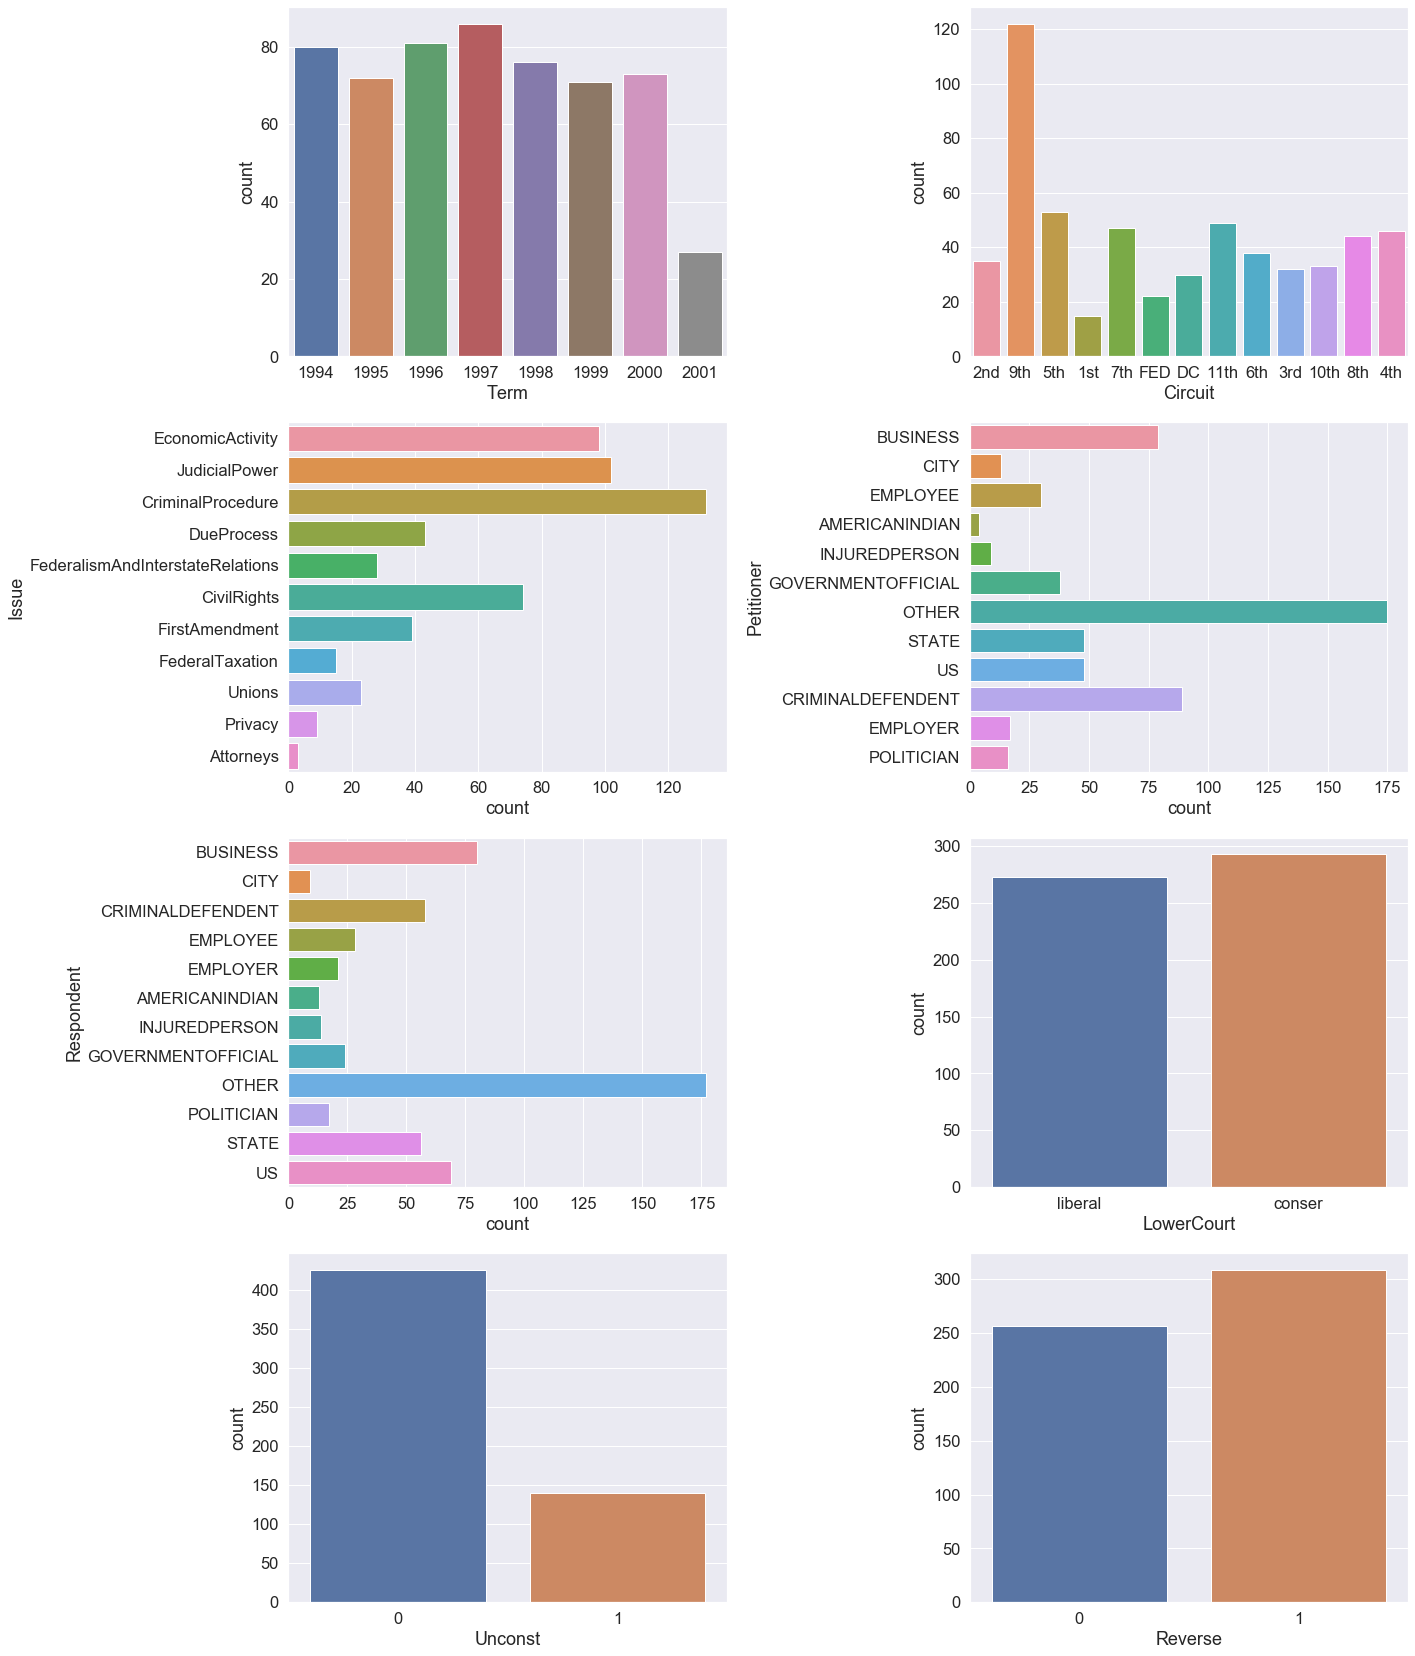

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Term)
plt.subplot(7,2,2)
sns.countplot(df.Circuit)
plt.subplot(7,2,3)
sns.countplot(y=df.Issue)
plt.subplot(7,2,4)
sns.countplot(y = df.Petitioner)
plt.subplot(7,2,5)
sns.countplot(y = df.Respondent)
plt.subplot(7,2,6)
sns.countplot(df.LowerCourt)
plt.subplot(7,2,7)
sns.countplot(df.Unconst)
plt.subplot(7,2,8)
sns.countplot(df.Reverse)
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,Term,Unconst,Reverse
Term,1.000000,0.033358,0.013982
Unconst,0.033358,1.000000,0.103371
Reverse,0.013982,0.103371,1.000000


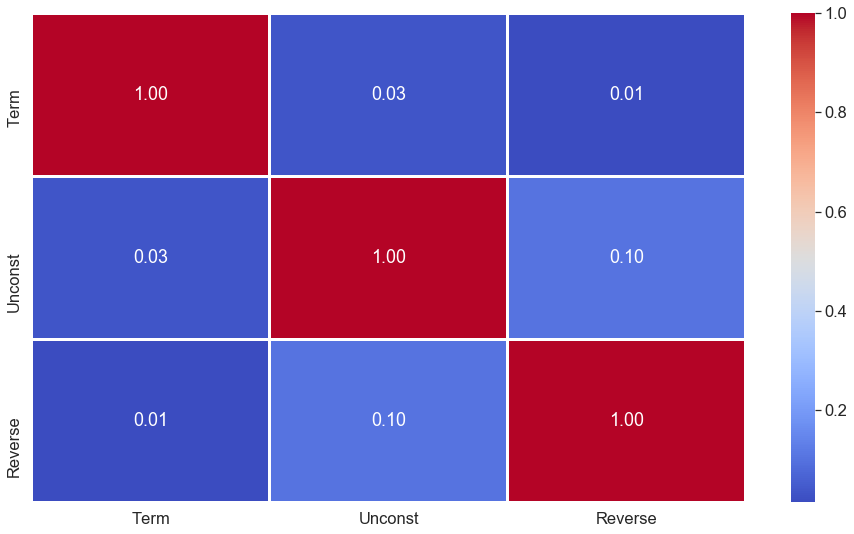

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

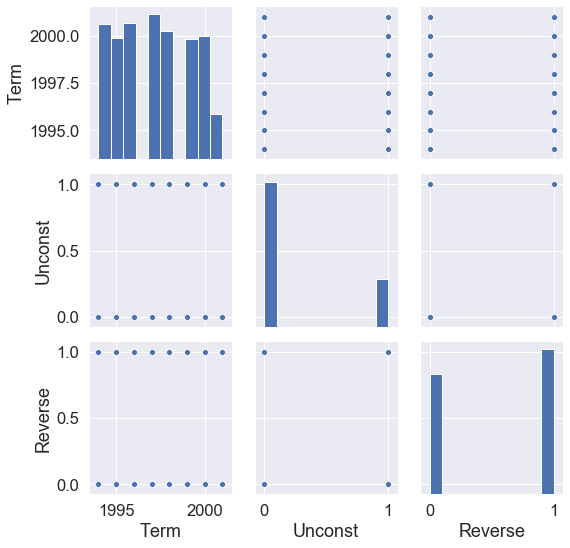

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

Docket        0
Term          0
Circuit       0
Issue         0
Petitioner    0
Respondent    0
LowerCourt    0
Unconst       0
Reverse       0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

### Treat Outliers

### Treat Data Types

### Drop unwanted features

In [14]:
df.columns

Index(['Docket', 'Term', 'Circuit', 'Issue', 'Petitioner', 'Respondent',
       'LowerCourt', 'Unconst', 'Reverse'],
      dtype='object')

In [15]:
df.drop(['Docket', 'Term'],axis=1,inplace=True)

In [16]:
df

,Circuit,Issue,Petitioner,Respondent,LowerCourt,Unconst,Reverse
0,2nd,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
1,9th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
2,5th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
3,1st,EconomicActivity,BUSINESS,BUSINESS,conser,0,1
4,7th,JudicialPower,BUSINESS,BUSINESS,conser,0,1
...,...,...,...,...,...,...,...
561,6th,CriminalProcedure,OTHER,US,conser,0,0
562,5th,CriminalProcedure,OTHER,US,liberal,0,1
563,9th,CriminalProcedure,OTHER,US,conser,1,0
564,DC,CivilRights,STATE,US,conser,0,0


In [17]:
df2 = pd.get_dummies(df,columns=['Circuit','Issue', 'Petitioner', 'Respondent','LowerCourt'],drop_first=True)

In [18]:
df2

,Unconst,Reverse,Circuit_11th,Circuit_1st,Circuit_2nd,Circuit_3rd,Circuit_4th,Circuit_5th,Circuit_6th,Circuit_7th,Circuit_8th,Circuit_9th,Circuit_DC,Circuit_FED,Issue_CivilRights,Issue_CriminalProcedure,Issue_DueProcess,Issue_EconomicActivity,Issue_FederalTaxation,Issue_FederalismAndInterstateRelations,Issue_FirstAmendment,Issue_JudicialPower,Issue_Privacy,Issue_Unions,Petitioner_BUSINESS,Petitioner_CITY,Petitioner_CRIMINALDEFENDENT,Petitioner_EMPLOYEE,Petitioner_EMPLOYER,Petitioner_GOVERNMENTOFFICIAL,Petitioner_INJUREDPERSON,Petitioner_OTHER,Petitioner_POLITICIAN,Petitioner_STATE,Petitioner_US,Respondent_BUSINESS,Respondent_CITY,Respondent_CRIMINALDEFENDENT,Respondent_EMPLOYEE,Respondent_EMPLOYER,Respondent_GOVERNMENTOFFICIAL,Respondent_INJUREDPERSON,Respondent_OTHER,Respondent_POLITICIAN,Respondent_STATE,Respondent_US,LowerCourt_liberal
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
562,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
563,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
564,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
df2.columns

Index(['Unconst', 'Reverse', 'Circuit_11th', 'Circuit_1st', 'Circuit_2nd',
       'Circuit_3rd', 'Circuit_4th', 'Circuit_5th', 'Circuit_6th',
       'Circuit_7th', 'Circuit_8th', 'Circuit_9th', 'Circuit_DC',
       'Circuit_FED', 'Issue_CivilRights', 'Issue_CriminalProcedure',
       'Issue_DueProcess', 'Issue_EconomicActivity', 'Issue_FederalTaxation',
       'Issue_FederalismAndInterstateRelations', 'Issue_FirstAmendment',
       'Issue_JudicialPower', 'Issue_Privacy', 'Issue_Unions',
       'Petitioner_BUSINESS', 'Petitioner_CITY',
       'Petitioner_CRIMINALDEFENDENT', 'Petitioner_EMPLOYEE',
       'Petitioner_EMPLOYER', 'Petitioner_GOVERNMENTOFFICIAL',
       'Petitioner_INJUREDPERSON', 'Petitioner_OTHER', 'Petitioner_POLITICIAN',
       'Petitioner_STATE', 'Petitioner_US', 'Respondent_BUSINESS',
       'Respondent_CITY', 'Respondent_CRIMINALDEFENDENT',
       'Respondent_EMPLOYEE', 'Respondent_EMPLOYER',
       'Respondent_GOVERNMENTOFFICIAL', 'Respondent_INJUREDPERSON',
       '

In [20]:
df2 = df2[['Unconst', 'Circuit_11th', 'Circuit_1st', 'Circuit_2nd',
       'Circuit_3rd', 'Circuit_4th', 'Circuit_5th', 'Circuit_6th',
       'Circuit_7th', 'Circuit_8th', 'Circuit_9th', 'Circuit_DC',
       'Circuit_FED', 'Issue_CivilRights', 'Issue_CriminalProcedure',
       'Issue_DueProcess', 'Issue_EconomicActivity', 'Issue_FederalTaxation',
       'Issue_FederalismAndInterstateRelations', 'Issue_FirstAmendment',
       'Issue_JudicialPower', 'Issue_Privacy', 'Issue_Unions',
       'Petitioner_BUSINESS', 'Petitioner_CITY',
       'Petitioner_CRIMINALDEFENDENT', 'Petitioner_EMPLOYEE',
       'Petitioner_EMPLOYER', 'Petitioner_GOVERNMENTOFFICIAL',
       'Petitioner_INJUREDPERSON', 'Petitioner_OTHER', 'Petitioner_POLITICIAN',
       'Petitioner_STATE', 'Petitioner_US', 'Respondent_BUSINESS',
       'Respondent_CITY', 'Respondent_CRIMINALDEFENDENT',
       'Respondent_EMPLOYEE', 'Respondent_EMPLOYER',
       'Respondent_GOVERNMENTOFFICIAL', 'Respondent_INJUREDPERSON',
       'Respondent_OTHER', 'Respondent_POLITICIAN', 'Respondent_STATE',
       'Respondent_US', 'LowerCourt_liberal', 'Reverse']]

In [21]:
df2

,Unconst,Circuit_11th,Circuit_1st,Circuit_2nd,Circuit_3rd,Circuit_4th,Circuit_5th,Circuit_6th,Circuit_7th,Circuit_8th,Circuit_9th,Circuit_DC,Circuit_FED,Issue_CivilRights,Issue_CriminalProcedure,Issue_DueProcess,Issue_EconomicActivity,Issue_FederalTaxation,Issue_FederalismAndInterstateRelations,Issue_FirstAmendment,Issue_JudicialPower,Issue_Privacy,Issue_Unions,Petitioner_BUSINESS,Petitioner_CITY,Petitioner_CRIMINALDEFENDENT,Petitioner_EMPLOYEE,Petitioner_EMPLOYER,Petitioner_GOVERNMENTOFFICIAL,Petitioner_INJUREDPERSON,Petitioner_OTHER,Petitioner_POLITICIAN,Petitioner_STATE,Petitioner_US,Respondent_BUSINESS,Respondent_CITY,Respondent_CRIMINALDEFENDENT,Respondent_EMPLOYEE,Respondent_EMPLOYER,Respondent_GOVERNMENTOFFICIAL,Respondent_INJUREDPERSON,Respondent_OTHER,Respondent_POLITICIAN,Respondent_STATE,Respondent_US,LowerCourt_liberal,Reverse
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
562,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
563,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
564,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Create and save processed dataset

In [22]:
#df2.to_csv("judgetrain.csv",index=False)

### Train Test Split

In [23]:
df2.shape

(566, 47)

In [24]:
X = df2.iloc[:,0:46]
y = df2.iloc[:,46]

In [25]:
X.values, y.values

(array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 1]], dtype=int64),
 array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0,

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((452, 46), (114, 46), (452,), (114,))

### Feature Scaling

In [28]:
X_train

,Unconst,Circuit_11th,Circuit_1st,Circuit_2nd,Circuit_3rd,Circuit_4th,Circuit_5th,Circuit_6th,Circuit_7th,Circuit_8th,Circuit_9th,Circuit_DC,Circuit_FED,Issue_CivilRights,Issue_CriminalProcedure,Issue_DueProcess,Issue_EconomicActivity,Issue_FederalTaxation,Issue_FederalismAndInterstateRelations,Issue_FirstAmendment,Issue_JudicialPower,Issue_Privacy,Issue_Unions,Petitioner_BUSINESS,Petitioner_CITY,Petitioner_CRIMINALDEFENDENT,Petitioner_EMPLOYEE,Petitioner_EMPLOYER,Petitioner_GOVERNMENTOFFICIAL,Petitioner_INJUREDPERSON,Petitioner_OTHER,Petitioner_POLITICIAN,Petitioner_STATE,Petitioner_US,Respondent_BUSINESS,Respondent_CITY,Respondent_CRIMINALDEFENDENT,Respondent_EMPLOYEE,Respondent_EMPLOYER,Respondent_GOVERNMENTOFFICIAL,Respondent_INJUREDPERSON,Respondent_OTHER,Respondent_POLITICIAN,Respondent_STATE,Respondent_US,LowerCourt_liberal
172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
543,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
231,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
127,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
359,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [29]:
X_test

,Unconst,Circuit_11th,Circuit_1st,Circuit_2nd,Circuit_3rd,Circuit_4th,Circuit_5th,Circuit_6th,Circuit_7th,Circuit_8th,Circuit_9th,Circuit_DC,Circuit_FED,Issue_CivilRights,Issue_CriminalProcedure,Issue_DueProcess,Issue_EconomicActivity,Issue_FederalTaxation,Issue_FederalismAndInterstateRelations,Issue_FirstAmendment,Issue_JudicialPower,Issue_Privacy,Issue_Unions,Petitioner_BUSINESS,Petitioner_CITY,Petitioner_CRIMINALDEFENDENT,Petitioner_EMPLOYEE,Petitioner_EMPLOYER,Petitioner_GOVERNMENTOFFICIAL,Petitioner_INJUREDPERSON,Petitioner_OTHER,Petitioner_POLITICIAN,Petitioner_STATE,Petitioner_US,Respondent_BUSINESS,Respondent_CITY,Respondent_CRIMINALDEFENDENT,Respondent_EMPLOYEE,Respondent_EMPLOYER,Respondent_GOVERNMENTOFFICIAL,Respondent_INJUREDPERSON,Respondent_OTHER,Respondent_POLITICIAN,Respondent_STATE,Respondent_US,LowerCourt_liberal
475,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
211,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
134,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
108,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
103,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
293,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
547,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
233,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Model Training

### Using XGBoost

In [30]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [31]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.359649
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.359649
[2]	validation_0-error:0.359649
[3]	validation_0-error:0.359649
[4]	validation_0-error:0.359649
[5]	validation_0-error:0.359649
[6]	validation_0-error:0.342105
[7]	validation_0-error:0.342105
[8]	validation_0-error:0.359649
[9]	validation_0-error:0.342105
[10]	validation_0-error:0.342105
[11]	validation_0-error:0.342105
[12]	validation_0-error:0.342105
[13]	validation_0-error:0.342105
[14]	validation_0-error:0.342105
[15]	validation_0-error:0.342105
[16]	validation_0-error:0.342105
Stopping. Best iteration:
[6]	validation_0-error:0.342105



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
y_pred = xgbmodel.predict(X_test)

In [33]:
y_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0], dtype=int64)

### Model Evaluation

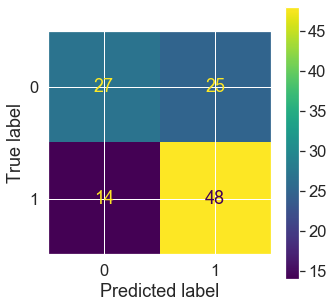

In [34]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbmodel,X_test,y_test,values_format='.4g',ax=ax)
plt.show()

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58        52
           1       0.66      0.77      0.71        62

    accuracy                           0.66       114
   macro avg       0.66      0.65      0.65       114
weighted avg       0.66      0.66      0.65       114



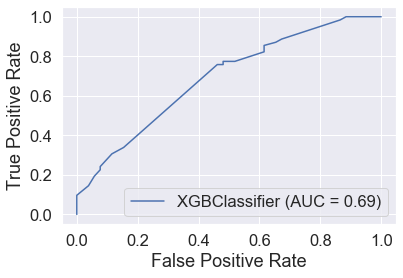

In [36]:
plot_roc_curve(xgbmodel,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [37]:
X.columns

Index(['Unconst', 'Circuit_11th', 'Circuit_1st', 'Circuit_2nd', 'Circuit_3rd',
       'Circuit_4th', 'Circuit_5th', 'Circuit_6th', 'Circuit_7th',
       'Circuit_8th', 'Circuit_9th', 'Circuit_DC', 'Circuit_FED',
       'Issue_CivilRights', 'Issue_CriminalProcedure', 'Issue_DueProcess',
       'Issue_EconomicActivity', 'Issue_FederalTaxation',
       'Issue_FederalismAndInterstateRelations', 'Issue_FirstAmendment',
       'Issue_JudicialPower', 'Issue_Privacy', 'Issue_Unions',
       'Petitioner_BUSINESS', 'Petitioner_CITY',
       'Petitioner_CRIMINALDEFENDENT', 'Petitioner_EMPLOYEE',
       'Petitioner_EMPLOYER', 'Petitioner_GOVERNMENTOFFICIAL',
       'Petitioner_INJUREDPERSON', 'Petitioner_OTHER', 'Petitioner_POLITICIAN',
       'Petitioner_STATE', 'Petitioner_US', 'Respondent_BUSINESS',
       'Respondent_CITY', 'Respondent_CRIMINALDEFENDENT',
       'Respondent_EMPLOYEE', 'Respondent_EMPLOYER',
       'Respondent_GOVERNMENTOFFICIAL', 'Respondent_INJUREDPERSON',
       'Respondent_

In [38]:
xgbmodel.get_booster().feature_names = ['Unconst', 'Circuit_11th', 'Circuit_1st', 'Circuit_2nd', 'Circuit_3rd',
       'Circuit_4th', 'Circuit_5th', 'Circuit_6th', 'Circuit_7th',
       'Circuit_8th', 'Circuit_9th', 'Circuit_DC', 'Circuit_FED',
       'Issue_CivilRights', 'Issue_CriminalProcedure', 'Issue_DueProcess',
       'Issue_EconomicActivity', 'Issue_FederalTaxation',
       'Issue_FederalismAndInterstateRelations', 'Issue_FirstAmendment',
       'Issue_JudicialPower', 'Issue_Privacy', 'Issue_Unions',
       'Petitioner_BUSINESS', 'Petitioner_CITY',
       'Petitioner_CRIMINALDEFENDENT', 'Petitioner_EMPLOYEE',
       'Petitioner_EMPLOYER', 'Petitioner_GOVERNMENTOFFICIAL',
       'Petitioner_INJUREDPERSON', 'Petitioner_OTHER', 'Petitioner_POLITICIAN',
       'Petitioner_STATE', 'Petitioner_US', 'Respondent_BUSINESS',
       'Respondent_CITY', 'Respondent_CRIMINALDEFENDENT',
       'Respondent_EMPLOYEE', 'Respondent_EMPLOYER',
       'Respondent_GOVERNMENTOFFICIAL', 'Respondent_INJUREDPERSON',
       'Respondent_OTHER', 'Respondent_POLITICIAN', 'Respondent_STATE',
       'Respondent_US', 'LowerCourt_liberal']

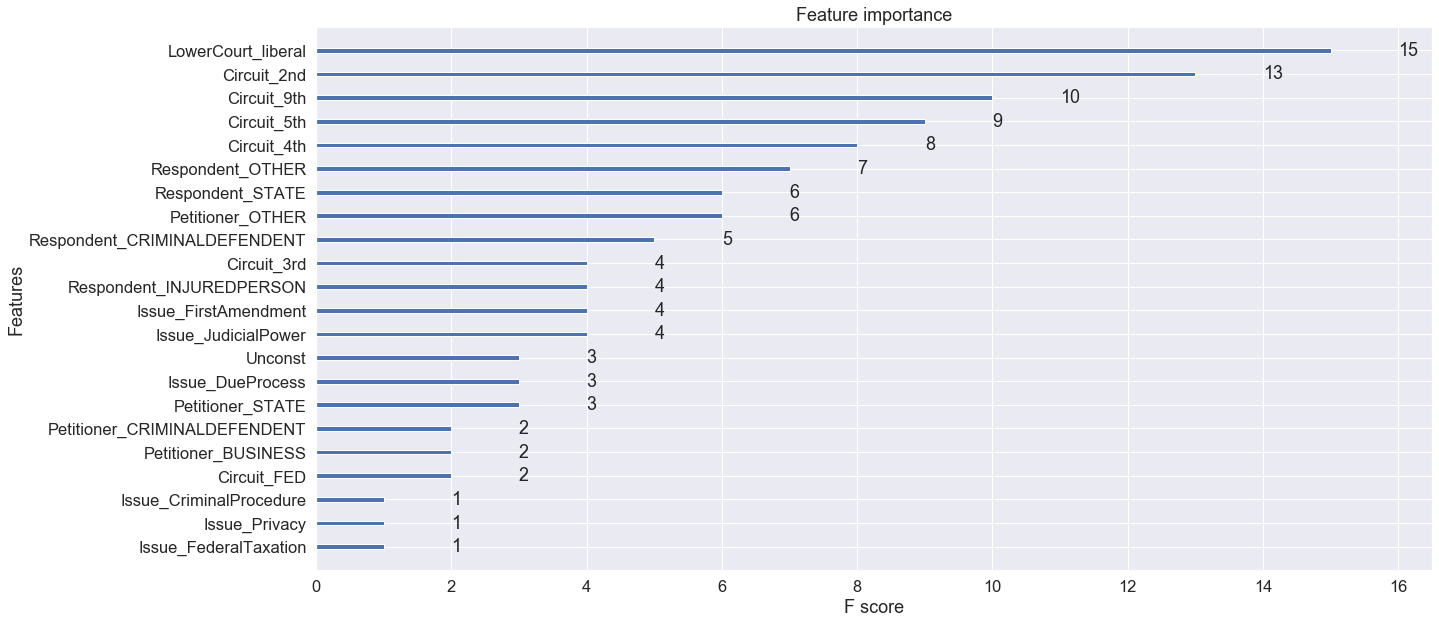

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

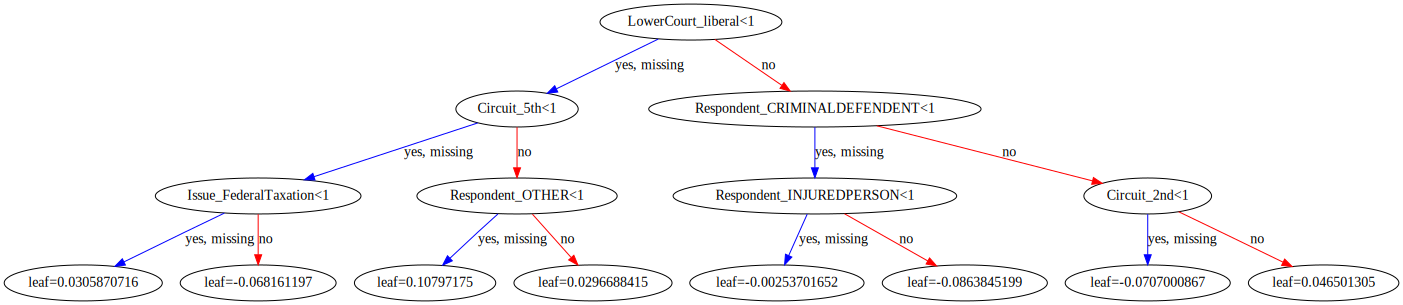

In [40]:
xgb.to_graphviz(xgbmodel,num_trees=10)

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [41]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='f1')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [42]:
cv.mean()

0.5600610529307868

In [43]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

### Model Tuning

In [44]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [45]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [46]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='f1')

In [47]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [48]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=18,
              learning rate=0.29, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7999999999999999,
              verbosity=1)

In [49]:
randm.best_score_

0.6800870898224878

In [50]:
randm.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 500,
 'min_child_weight': 2,
 'max_depth': 6,
 'learning rate': 0.29,
 'gamma': 18,
 'colsample_bytree': 0.7999999999999999}